## Imports

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchviz import make_dot

from PIL import Image
import random

from sklearn.metrics import confusion_matrix
import itertools

import os

## Machine Learning

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
total_dir = "fruit_dataset"
test_dir = "fruit_dataset/test"
val_dir = "fruit_dataset/val"
train_dir = "fruit_dataset/train"

In [ ]:
width_mean = 300
height_mean = 300

transform = transforms.Compose([transforms.Resize((width_mean, height_mean)), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
total_set = datasets.ImageFolder(total_dir, transform)
test_set = datasets.ImageFolder(test_dir, transform)
val_set = datasets.ImageFolder(val_dir, transform)
train_set = datasets.ImageFolder(train_dir, transform)

In [ ]:
batch_size = 64

n_total = len(total_set)  # total number of examples
n_test = len(test_set) # take 20% for test
n_val = len(val_set) # take 10% for validation
n_train = len(train_set) # take the other 70% for training
print('total_set: ', n_total, # verify the dataset separated correctly
      'test: ', n_test,
      'val: ', n_val,
      'train: ', n_train)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle= True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle= False)

classes = ('Acceptable_Apple', 'Acceptable_Banana', 'Acceptable_Guava', 'Acceptable_Lemon',
           'Acceptable_Orange', 'Acceptable_Pomegranate', 'Bad_Apple', 'Bad_Banana', 'Bad_Guava',
           'Bad_Lemon', 'Bad_Orange', 'Bad_Pomegranate', 'Good_Apple', 'Good_Banana', 'Good_Guava',
           'Good_Lemon', 'Good_Orange', 'Good_Pomegranate')

In [ ]:
# functions to show an image

def showimg(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
showimg(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # For first number, use 1 for B/W images, use 3 for color images
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(5, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.do1 = nn.Dropout(0.4)
        self.do2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1936, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 18)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.do1(x)
        x = F.relu(self.fc1(x))
        x = self.do1(x)
        x = F.relu(self.fc2(x))
        x = self.do2(x)
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode ='min', factor=0.1, patience=2, threshold=0.025, threshold_mode='abs')

In [ ]:
epoch_list = []
train_loss_list = []
val_loss_list = []
accuracy_list = []

In [ ]:
for epoch in range(40):  # loop over the dataset multiple times

    training_loss = 0.0
    val_loss = 0.0
    net.train()
    count = 1
    for data, target in train_loader:
      # print("train_loader: " + str(count) + "/" + str(len(train_loader)))
      if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = net(data)
      loss = criterion(output, target)
      # print("loss:", loss.item())
      # scheduler.step(loss)
      loss.backward()
      optimizer.step()
      training_loss += loss.item() * data.size(0)
      count += 1


    # validate the model #
    net.eval()
    number_correct, number_data = 0, 0
    for data, target in val_loader:
      if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
      output = net(data)
      loss = criterion(output, target)
      # scheduler.step(loss)
      val_loss += loss.item() * data.size(0)

    # print statistics
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    number_correct += sum(correct)
    number_data += correct.shape[0]

    train_loss = training_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    accuracy = (100 * number_correct / number_data)

    epoch_list.append(epoch)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    accuracy_list.append(accuracy)
    print('Epoch: {} \n-----------------\n \tTraining Loss: {:.6f} \t Validation Loss: {:.6f} \t accuracy : {:.4f}% '.format(epoch, train_loss, val_loss, accuracy))

net.to('cpu')

print('Finished Training')

In [ ]:
# If training loss and validation loss converge and decrease with more epochs, then the fitting is done properly
plt.figure()
plt.plot(epoch_list, train_loss_list)
plt.plot(epoch_list, val_loss_list)
plt.title("Training and Validation Loss by Epoch")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"], fontsize="x-large")
plt.show()

In [ ]:
plt.figure()
plt.plot(epoch_list,accuracy_list)
plt.title("Model Prediction Accuracy by Epoch")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
torch.save(net.state_dict(), "weights.pt")

In [ ]:
model = Net()
model.load_state_dict(torch.load("weights.pt"))
model.eval()

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
outputs = net(images)

In [ ]:
make_dot(outputs.mean(), params=dict(model.named_parameters()))

In [ ]:
make_dot(outputs.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
outputs = net(images)

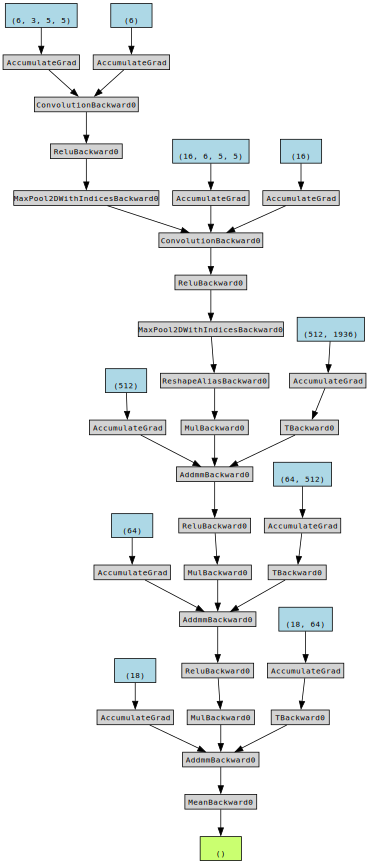

In [14]:
make_dot(outputs.mean(), params=dict(model.named_parameters()))

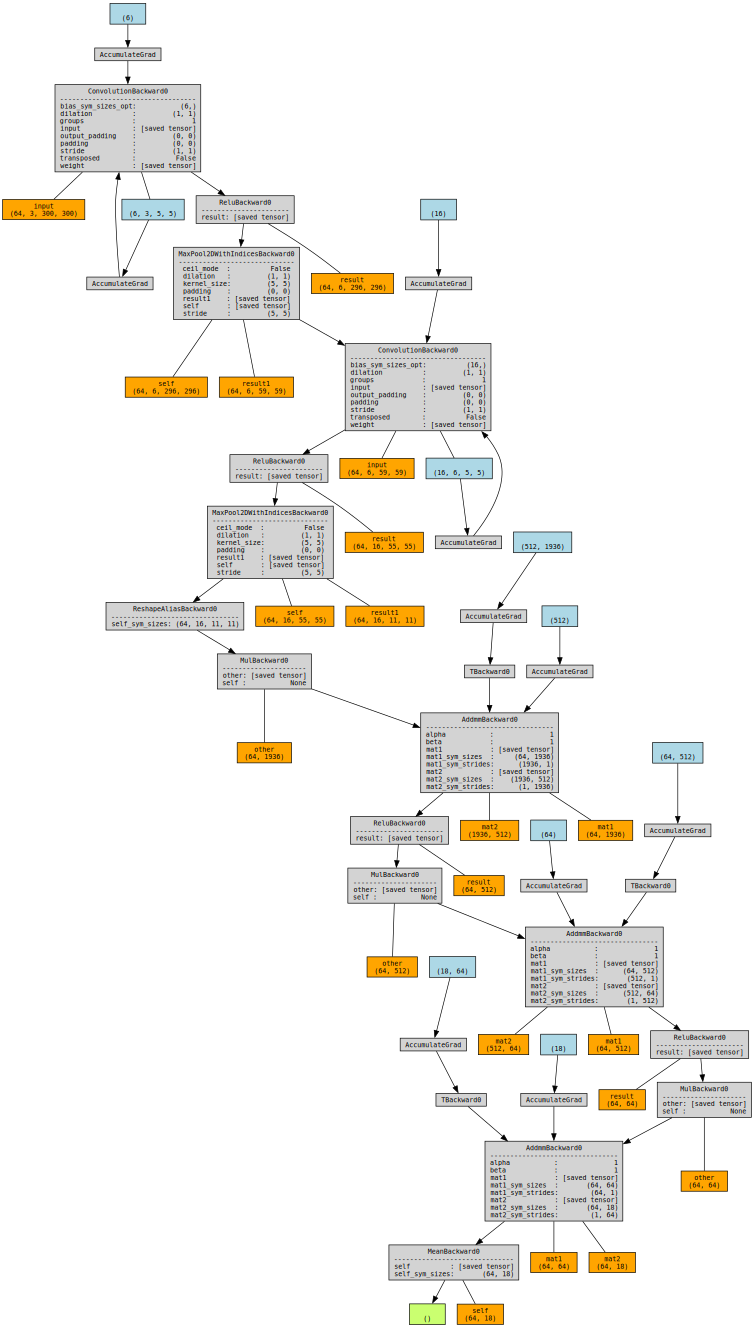

In [15]:
make_dot(outputs.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

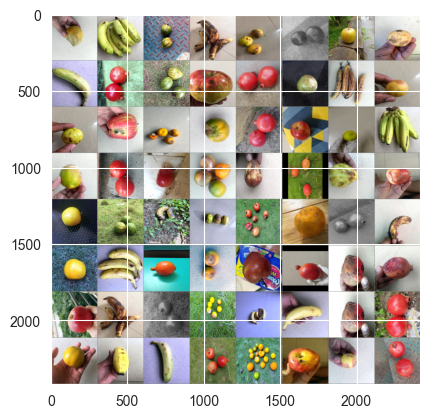

True labels:  Bad_Orange Good_Banana Good_Guava Bad_Banana Bad_Lemon Good_Pomegranate Good_Apple Bad_Guava Good_Banana Good_Pomegranate Good_Guava Bad_Apple Good_Pomegranate Good_Apple Bad_Banana Bad_Lemon Bad_Lemon Bad_Apple Acceptable_Orange Bad_Orange Good_Pomegranate Good_Apple Good_Lemon Good_Banana Bad_Orange Good_Pomegranate Good_Apple Bad_Orange Bad_Guava Good_Pomegranate Bad_Guava Bad_Apple Good_Apple Good_Guava Bad_Banana Acceptable_Guava Acceptable_Pomegranate Bad_Orange Good_Pomegranate Bad_Banana Good_Orange Good_Banana Good_Pomegranate Bad_Lemon Good_Apple Good_Pomegranate Bad_Pomegranate Bad_Pomegranate Good_Apple Bad_Banana Good_Pomegranate Acceptable_Lemon Acceptable_Banana Good_Banana Bad_Pomegranate Good_Pomegranate Good_Orange Good_Banana Good_Banana Good_Pomegranate Acceptable_Orange Bad_Apple Bad_Lemon Good_Pomegranate
Predicted Labels:  Bad_Orange Good_Banana Good_Guava Bad_Banana Bad_Lemon Good_Pomegranate Good_Apple Bad_Guava Good_Banana Good_Pomegranate Good_G

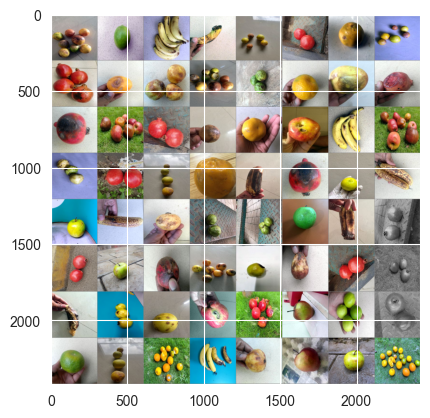

True labels:  Bad_Lemon Good_Lemon Good_Banana Bad_Banana Acceptable_Lemon Good_Pomegranate Good_Orange Acceptable_Lemon Acceptable_Pomegranate Bad_Orange Bad_Guava Bad_Lemon Good_Guava Good_Orange Bad_Apple Bad_Pomegranate Bad_Pomegranate Acceptable_Apple Good_Pomegranate Bad_Lemon Good_Orange Bad_Apple Good_Banana Acceptable_Apple Acceptable_Guava Good_Pomegranate Acceptable_Lemon Bad_Orange Bad_Banana Bad_Pomegranate Good_Lemon Bad_Banana Good_Apple Bad_Banana Bad_Guava Good_Guava Good_Guava Good_Apple Bad_Banana Good_Pomegranate Good_Pomegranate Good_Apple Bad_Pomegranate Bad_Lemon Good_Guava Bad_Guava Good_Pomegranate Good_Pomegranate Bad_Banana Good_Guava Bad_Lemon Bad_Apple Acceptable_Pomegranate Good_Apple Good_Lemon Good_Pomegranate Good_Orange Acceptable_Lemon Acceptable_Orange Acceptable_Banana Bad_Guava Good_Apple Good_Apple Acceptable_Orange
Predicted Labels:  Bad_Lemon Good_Lemon Good_Banana Bad_Banana Acceptable_Lemon Good_Pomegranate Good_Orange Acceptable_Lemon Accepta

In [27]:
def test_model(numTests):
  for i in range(numTests):
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle= True, num_workers = 2)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    labels = labels.cpu().detach().numpy()
    showimg(torchvision.utils.make_grid(images))
    print('True labels: ', ' '.join(f'{classes[label]}' for label in labels))
    outputs = net(images)
    _, preds = torch.max(outputs, 1)
    print('Predicted Labels: ', ' '.join(f'{classes[pred]}' for pred in preds))

test_model(2)

In [43]:
raw_pred_label = []
raw_true_label = []

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    j = 0
    for data in test_loader:
        j+= 1
        images, labels = data
        raw_true_label.append(' '.join(f'{classes[label]}' for label in labels))
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        raw_pred_label.append(' '.join(f'{classes[pred]}' for pred in predicted))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(j)

print(f'Accuracy of the network on the 2595 test images: {100 * correct / total} %')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
Accuracy of the network on the 2595 test images: 95.76107899807322 %


## Model Performance Visualization
- We use a confusion matrix. All predictions made along the top left to bottom right diagonal are correct. All other are false.

In [44]:
# Format predicted labels better
pred_labels = []
for i in range(len(raw_pred_label)):
    pred_labels.extend(raw_pred_label[i].split())
len(pred_labels)

2595

In [45]:
# Format true labels better
true_labels = []
for i in range(len(raw_true_label)):
    true_labels.extend(raw_true_label[i].split())
len(true_labels)

2595

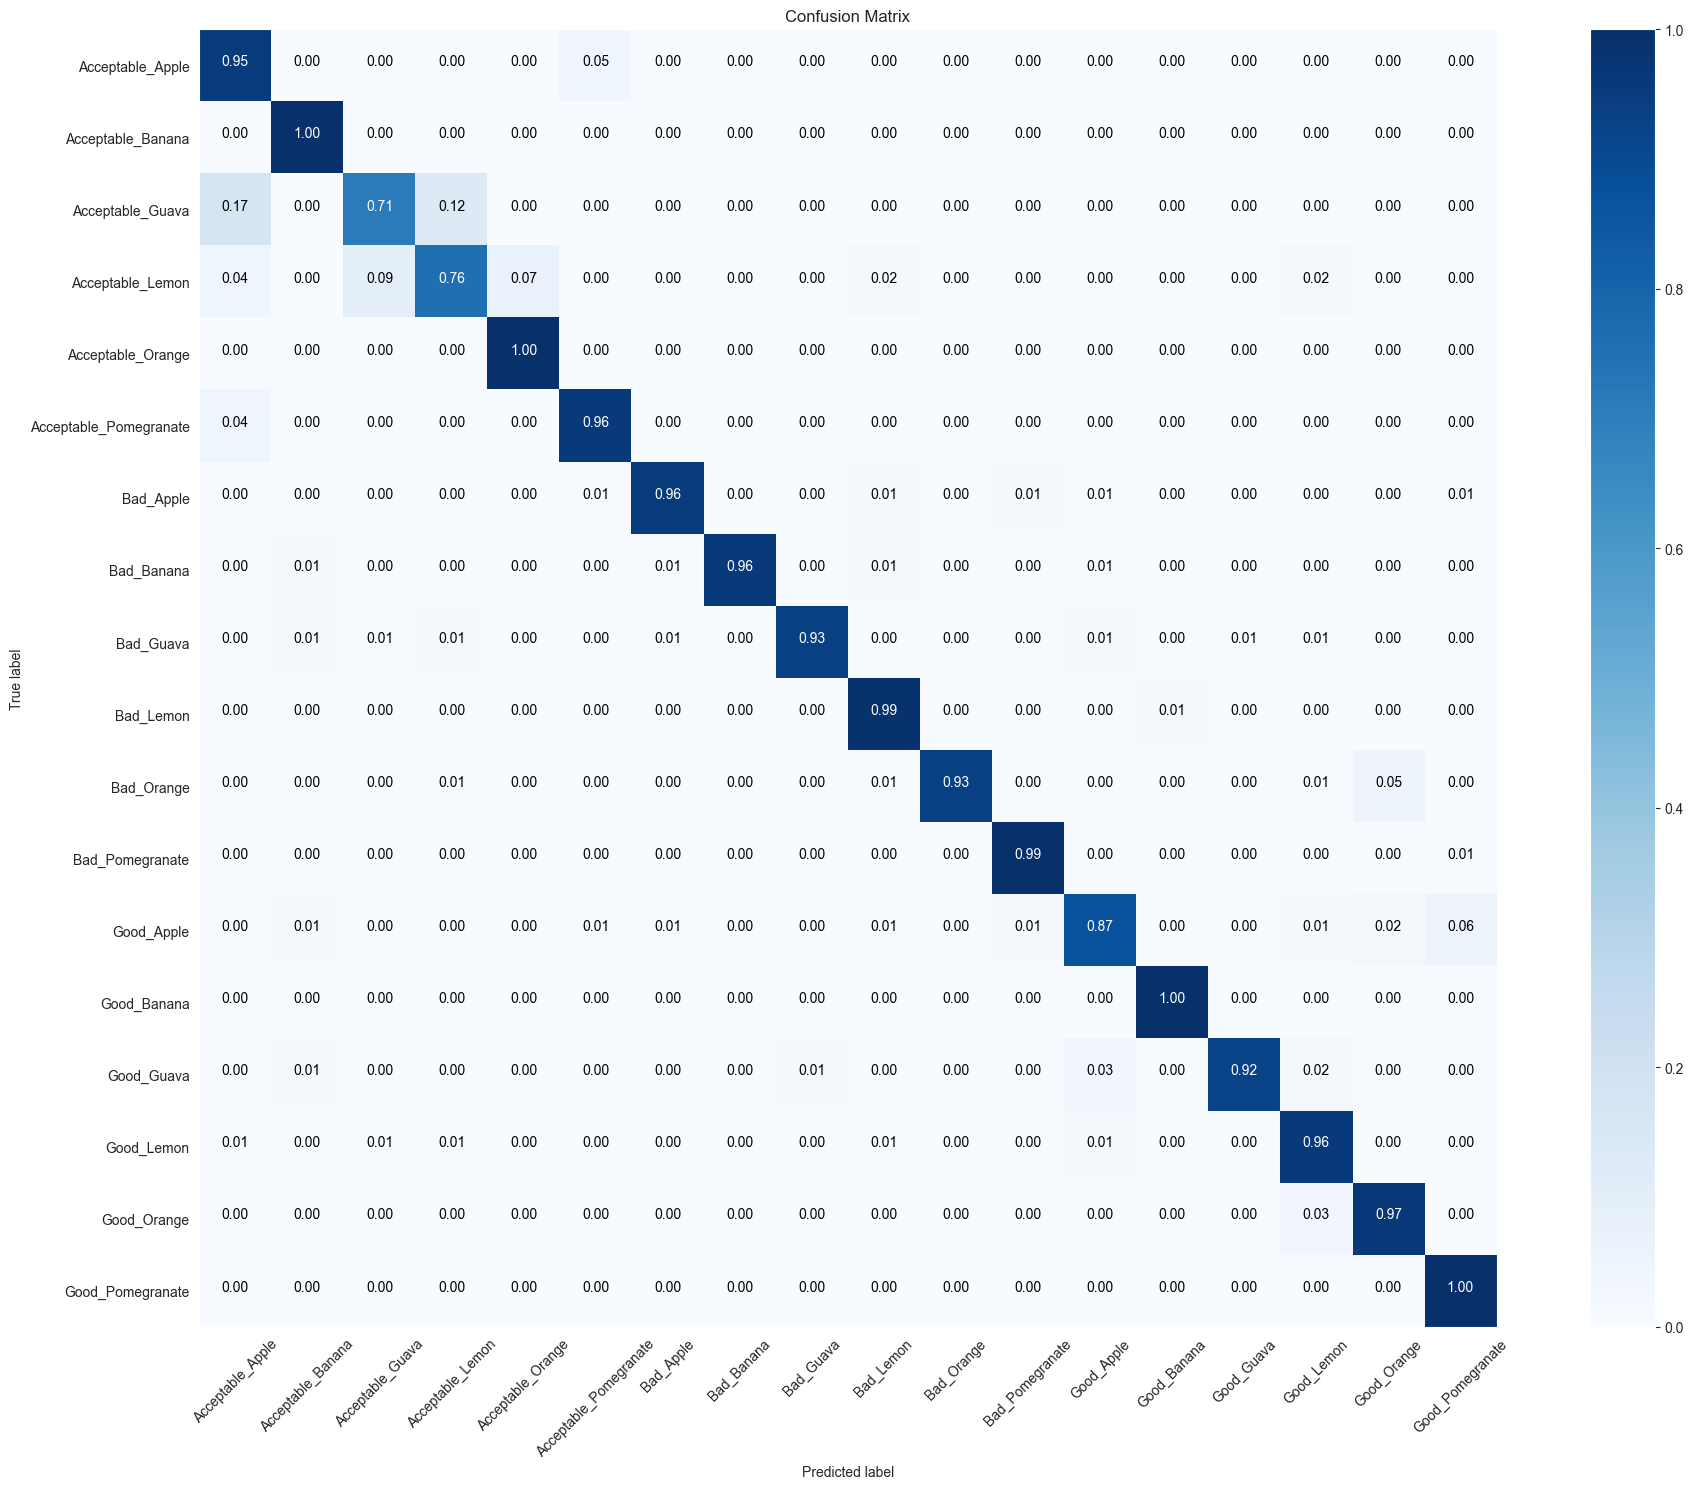

In [48]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(8, 6)):
    """
    This function plots the confusion matrix.

    Parameters:
        y_true (list): List of ground truth labels.
        y_pred (list): List of predicted labels.
        classes (list): List of class labels in the dataset.
        normalize (bool): If True, the values in the confusion matrix will be normalized.
        title (str): Title of the confusion matrix plot.
        cmap (matplotlib colormap): Colormap to be used for the heatmap.
        figsize (tuple): Size of the figure (width, height) in inches.
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Example usage:
class_labels = list(classes)

# Plot the confusion matrix with increased dimensions
plot_confusion_matrix(true_labels, pred_labels, classes=class_labels, normalize=True, title='Confusion Matrix', figsize=(20,15))

plt.show()